In [3]:
import numpy as np
from typing import Dict, Tuple, List
import csv
from dataclasses import dataclass
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import matplotlib
import matplotlib.pyplot as plt
import math
import random

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class Env: 
    _condition_symptom_probabilities: Dict[str, Dict[str, float]] # conditions with symptoms and their probabilities
    _actions: list[str] # symptoms
    _init_state: np.array
    _current_state: np.array
    _img: np.array
    _condition: str 
    _symptoms_of_condition: Dict[str, float] # symptoms of conditions
    _supported_conditions : list[str]
    
    def __init__(self,
                 img: np.array,
                 condition: str = None,
                ) -> None:  
        self._supported_conditions=["pneumonia", "pneumothorax", "lung cancer", "pleural effusion", "cardiomyopathy"]
        self._img = img
        if(condition is None): 
            condition = random.sample(self._supported_conditions,1)[0]
        self._condition = condition
        
        # initialize condition_symptom_probabilities from HealthKnowledgeGraph.csv
        self._condition_symptom_probabilities = self.load_condition_symptom_probabilities()
        #print(self._condition_symptom_probabilities['pneumothorax'])

        # check if condition is valid
        if(self._condition not in self._condition_symptom_probabilities.keys()):
            raise ValueError('Unknow Condition: ' + condition + '. Please choose one of the following: ' + str(self._condition_symptom_probabilities.keys()))
        
        # init symptoms_of_condition for easier access
        self._symptoms_of_condition = self._condition_symptom_probabilities[self._condition]  
        #print("_symptoms_of_condition")
        #print(len(self._symptoms_of_condition))
        #print(self._symptoms_of_condition)
        # init actions
        self._actions = list()
        for condition in self._condition_symptom_probabilities.keys(): 
            for symptom in list(self._condition_symptom_probabilities[condition]):
                if symptom not in self._actions:
                    self._actions.append(symptom)
        #print(" actions ")
        #print(len(self._actions))            
        #print(self._actions)
        
        # init init_state = vector with cnn output (probabilities per condition) and history of asked symptoms (0=not asked, 1=symptom is present, -1=symptom is not present)
        visual_prior = np.random.uniform(size=(len(self._supported_conditions))) #TODO: replace with cnn output
        #visual_prior = np.ones(shape=(len(self._condition_symptom_probabilities.keys())))
        self._init_state = np.concatenate((visual_prior,np.zeros((len(self._actions)))), axis=0)
        self._current_state = self._init_state
        
        
        n_cnn_output_probabilities = len(self._supported_conditions)
        n_history_elements = len(self._actions)
        self.n_observations = n_cnn_output_probabilities + n_history_elements
        self.n_actions = len(self._actions)
        
           
    def load_condition_symptom_probabilities(self) -> Dict[str, Dict[str, float]]:
        condition_symptom_probabilities = dict()

        with open('HealthKnowledgeGraph.csv', newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            header = next(reader)  

            for row in reader:
                # to make it case insensitive
                condition = row[0].lower()  

                # if condition is in the supported conditions list then add the symptoms to the list
                if condition not in self._supported_conditions:
                    continue

                symptoms_and_probs = row[1].split(',')

                symptom_probabilities = dict()
                for symptom_prob in symptoms_and_probs:
                    symptom, prob = map(str.strip, symptom_prob.split('('))
                    # to remove the last parentheses ')'
                    prob = float(prob[:-1])  
                    symptom_probabilities[symptom] = prob

                condition_symptom_probabilities[condition] = symptom_probabilities

        return condition_symptom_probabilities

    def posterior_of_condition(self, condition: str) -> float: 
        #TODO: What is the correct likelihood calculation? If we use multiplication as in P(x,y)=P(x)*P(y), the likelihood gets smaller 
        #and nothing prevents the model from asking symptoms which are not related to the condition.
        likelihood=0 
        for idx, symptom in enumerate(self._actions):
            patient_answer = self._current_state[idx+len(self._condition_symptom_probabilities.keys())]
            #if (patient_answer==1) and (symptom not in self._condition_symptom_probabilities[condition].keys()):
            #    likelihood*= 0
            #elif (patient_answer==-1) and (symptom not in self._condition_symptom_probabilities[condition].keys()):
            #    likelihood*=1
            if (symptom not in self._condition_symptom_probabilities[condition].keys()):
                #TODO: Do we have to punish the model if a symptom is positive and is not related to the condition?
                continue 
            elif patient_answer==1:
                likelihood+=self._condition_symptom_probabilities[condition][symptom]
            elif patient_answer==-1:
                likelihood+=(1-self._condition_symptom_probabilities[condition][symptom]) 

        prior = self._current_state[list(self._condition_symptom_probabilities.keys()).index(condition)]
        return likelihood+prior
    
    def reward(self) -> float:
        #TODO: Is it a problem when the reward gets smaller and smaller?
        punishment=0
        for i in range(len(self._actions)):
            patient_answer = self._current_state[i+len(self._condition_symptom_probabilities.keys())]
            if (patient_answer!=0):
                punishment+=0.2
        return self.posterior_of_condition(self._condition)-punishment
    
    def has_symptom(self, symptom: str) -> bool:
        if symptom not in self._symptoms_of_condition:
            return False
        else:
            phi = np.random.uniform()
            
            return phi <= self._symptoms_of_condition[symptom]

    def step(self, action_idx: int) -> Transition: 
        action = self._actions[action_idx]
        old_state = self._current_state.copy()
        self._current_state[len(self._condition_symptom_probabilities.keys()) + action_idx] = 1 if self.has_symptom(action) else -1
        new_state = self._current_state
        reward = self.reward()

        # update replay buffer
        replay_buffer.push(old_state, action_idx, new_state if reward > 0 else None, reward)

        return Transition(old_state, action_idx, new_state, reward)

    
    def reset(self) -> np.array:
        self._current_state = self._init_state
        return self._current_state

In [7]:
# Testing simulated patient answers
myTestEnv=Env(np.array([]), 'pneumonia')
print("Symptoms for pneumonia:")
print(myTestEnv._condition_symptom_probabilities['pneumonia'])


Symptoms for pneumonia:
{'coughing': 0.402, 'fever': 0.208, 'shortness of breath': 0.156, 'cough with phlegm': 0.138, 'chills': 0.091, 'lethargy': 0.063, 'low oxygen in the body': 0.06, 'weakness': 0.043, 'wheezing': 0.042, 'fatigue': 0.037, 'infection': 0.034, 'dry cough': 0.03, 'malaise': 0.03, 'fast heart rate': 0.027, 'confusion': 0.024, 'phlegm': 0.018, 'respiratory distress': 0.018, 'low blood pressure': 0.017, 'fast breathing': 0.016, 'chest pain worsened by breathing': 0.014, 'mental confusion': 0.014, 'coughing up blood': 0.013, 'diarrhea': 0.012, 'sore throat': 0.01, 'difficulty breathing': 0.01, 'night sweats': 0.009, 'persistent cough': 0.009, 'fluid in the lungs': 0.008}


In [8]:
from collections import namedtuple, deque

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# DQN Model
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [9]:
# Replay Buffer
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def __len__(self):
        return len(self.memory)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

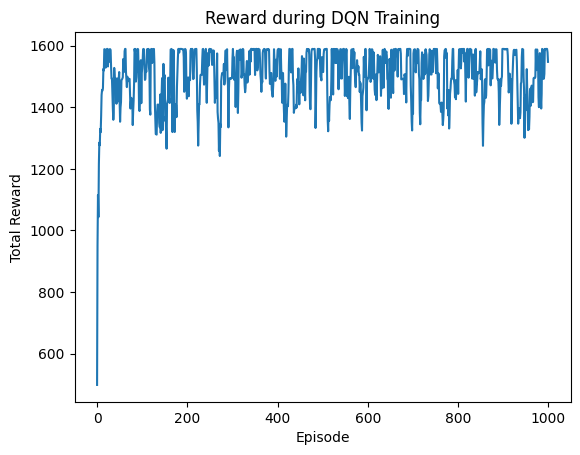

In [10]:
batch_size = 8
gamma = 0.8
target_update_frequency = 10
num_episodes = 1000
max_steps_per_episode = 200

# Initialize the environment and DQN model
env = Env(img=np.zeros((256, 256, 3)))  # for example image (256, 256, 3)
dqn = DQN(env.n_observations, env.n_actions)
target_dqn = DQN(env.n_observations, env.n_actions)
target_dqn.load_state_dict(dqn.state_dict())
target_dqn.eval()

optimizer = optim.Adam(dqn.parameters())
replay_buffer = ReplayBuffer(capacity=1000)

# rewards for plotting
episode_rewards = []

max_steps_per_episode = 100
    
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    for t in range(max_steps_per_episode):
        # it selects an action using epsilon-greedy policy
        epsilon = 0.2
        if random.random() < epsilon:
            action = random.randint(0, env.n_actions - 1)
        else:
            with torch.no_grad():
                q_values = dqn(torch.tensor(state, dtype=torch.float32))
                action = q_values.argmax().item()

        # Take action in the environment
        transition = env.step(action)

        # Add transition to replay buffer
        replay_buffer.push(*transition)

        # a random batch from the replay buffer and perform DQN update
        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            batch = Transition(*zip(*transitions))

            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
            non_final_next_states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in batch.next_state if s is not None])

            state_batch = torch.stack([torch.tensor(s, dtype=torch.float32) for s in batch.state])
            action_batch = torch.tensor(batch.action)
            reward_batch = torch.tensor(batch.reward)
            next_state_values = torch.zeros(batch_size)

            next_state_values[non_final_mask] = target_dqn(non_final_next_states).max(1)[0].detach()

            expected_state_action_values = reward_batch + gamma * next_state_values
            state_action_values = dqn(state_batch).gather(1, action_batch.view(-1, 1))

            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        episode_reward += transition.reward

    episode_rewards.append(episode_reward)
    
    if episode % target_update_frequency == 0:
        target_dqn.load_state_dict(dqn.state_dict())

    #print(f"Episode {episode}, Reward: {episode_reward}")
    
# plotting the rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward during DQN Training')
plt.show()
